In [1]:
# reload modules before executing user code
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
# Prediction interface for Cog ⚙️
from cog import BasePredictor, Input, Path
import os
from typing import List
import time
import datetime
import re
import math

import torch
from PIL import Image
from diffusers import (
    PNDMScheduler,
    DDIMScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
    HeunDiscreteScheduler,
)

from diffusers import (
    StableDiffusionInpaintPipeline,
    StableDiffusionControlNetInpaintPipeline,
    ControlNetModel,
)

from lora import inject_trainable_lora, monkeypatch_or_replace_lora, monkeypatch_remove_lora
from image_processing import apply_canny, crop

class KarrasDPM:
    def from_config(config):
        return DPMSolverMultistepScheduler.from_config(config, use_karras_sigmas=True)


SCHEDULERS = {
    "DDIM": DDIMScheduler,
    "DPMSolverMultistep": DPMSolverMultistepScheduler,
    "HeunDiscrete": HeunDiscreteScheduler,
    "KarrasDPM": KarrasDPM,
    "K_EULER_ANCESTRAL": EulerAncestralDiscreteScheduler,
    "K_EULER": EulerDiscreteScheduler,
    "PNDM": PNDMScheduler,
}

CONTROLNETS = {
    "canny": "lllyasviel/sd-controlnet-canny",
}

MAX_SIZE = 1024

MODEL_CACHE = "./checkpoints"

MODEL_FILENAME = "Realistic_Vision_V5.1-inpainting.safetensors"
VAE_FILENAME = "vae-ft-mse-840000-ema-pruned.safetensors"
LORA_FILENAMES = ["lora_white_wall.pt", "lora_white_wall_v2.pt", "lora_brick_wall.pt"]

LORA_DICT = {
    "white_wall": {
        "rank": 8,
        "scale": 0.9,
        "target_replace_module": {"CrossAttention", "Attention", "GEGLU"},
        "filename": "lora_white_wall.pt",
    },
    "white_wall_v2": {
        "rank": 8,
        "scale": 0.9,
        "target_replace_module": {"CrossAttention", "Attention", "GEGLU"},
        "filename": "lora_white_wall_v2.pt",
    },
    "brick_wall": {
        "rank": 8,
        "scale": 0.9,
        "target_replace_module": {"CrossAttention", "Attention", "GEGLU"},
        "filename": "lora_brick_wall.pt",
    },
    "kvist_window": {
        "rank": 8,
        "scale": 1,
        "target_replace_module": {"CrossAttention", "Attention", "GEGLU"},
        "filename": "kvist_windows_lora_135.safetensors",
    },
}

CANNY_TRIGGER_WORDS = ['wall', 'walls', 'facade', 'facades']

WHITE_LORA_TRIGGER_WORDS = ['white_facade']

In [30]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


img_url = "C:/Users/Facundo/Desktop/ARKED/training/textual_inversion/testing_kitchens/images/andrea_room.jpg"
mask_url = "C:/Users/Facundo/Desktop/ARKED/training/textual_inversion/testing_kitchens/images/mask.png"

init_image = PIL.Image.open(img_url).resize((512, 512))
mask_image = PIL.Image.open(mask_url).resize((512, 512))

In [5]:
mask_image = mask_image.convert("L")

In [42]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    MODEL_CACHE,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [110]:
from safetensors import safe_open

file = safe_open('checkpoints/easynegative.safetensors', framework="pt", device=0)
file.keys()[0] = 'easy_negative'

In [76]:
tensor = file.get_tensor('emb_params')

In [77]:
import torch
from safetensors.torch import save_file

tensors = {
    "easynegative": tensor
}
save_file(tensors, "checkpoints/easynegative_new.safetensors")

In [7]:
pipe.load_textual_inversion('checkpoints/easynegative.safetensors')

In [43]:
pipe.load_textual_inversion('C:/Users/Facundo/Desktop/ARKED/training/textual_inversion/testing_kitchens/learned_embeds-step-1000.bin')

In [5]:
pipe.load_textual_inversion('C:/Users/Facundo/Desktop/ARKED/training/textual_inversion/testing_solar_panels/learned_embeds.bin')

In [6]:
pipe.load_textual_inversion('C:/Users/Facundo/Desktop/ARKED/training/textual_inversion/testing_kvist/learned_embeds.bin')

In [20]:
pipe.tokenizer.encode('<arked_kitchen>')

[49406, 49408, 49407]

In [13]:
pipe.load_lora_weights('C:/Users/Facundo/Desktop/ARKED/loras/solar_panels/solar_panels_2_lora_240.safetensors')

In [192]:
pipe.unload_lora_weights()

In [ ]:
pipe.to('cuda')

In [22]:
torch.cuda.empty_cache()

In [1]:
prompt = "kitchen <arked_kitchen>"
negative_prompt = "easynegative"

g_cuda = torch.Generator(device='cuda').manual_seed(42)
num_outputs=2

image = pipe(prompt=[prompt] * num_outputs if prompt is not None else None,
             # negative_prompt=[negative_prompt] * num_outputs,
             image=init_image, 
             mask_image=mask_image, 
             generator=g_cuda,
             strength=1,
             num_inference_steps=20,
             ).images

NameError: name 'torch' is not defined

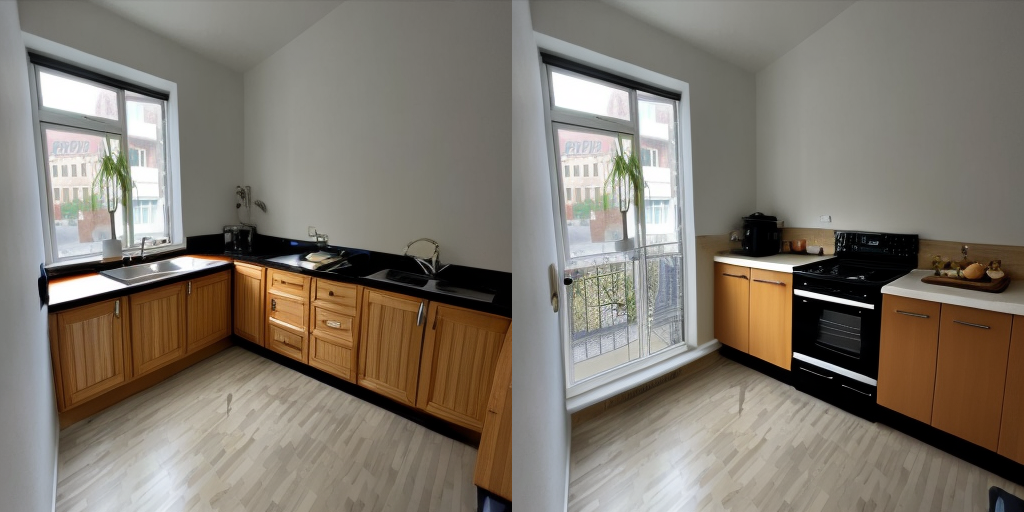

In [47]:
image_grid(image, 1, num_outputs)

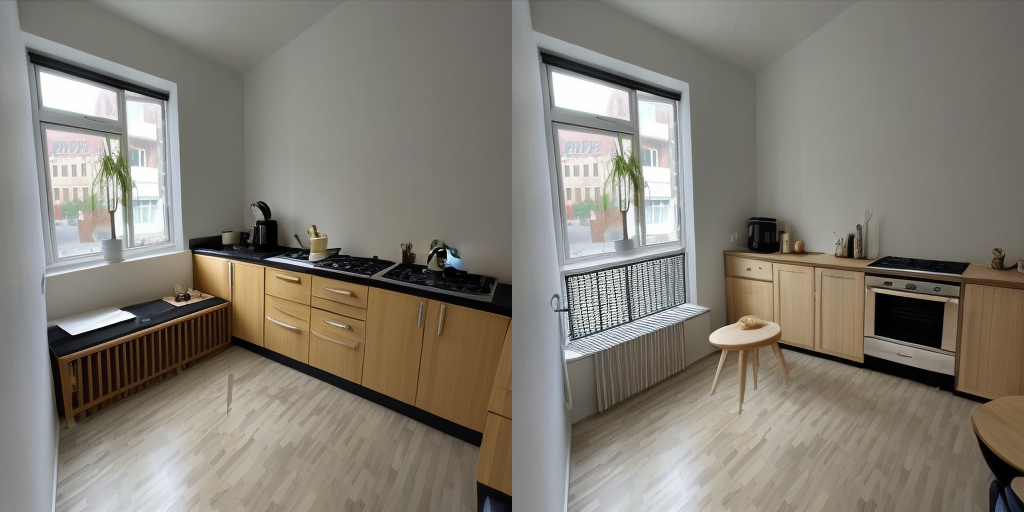

In [25]:
image_grid(image, 1, num_outputs)

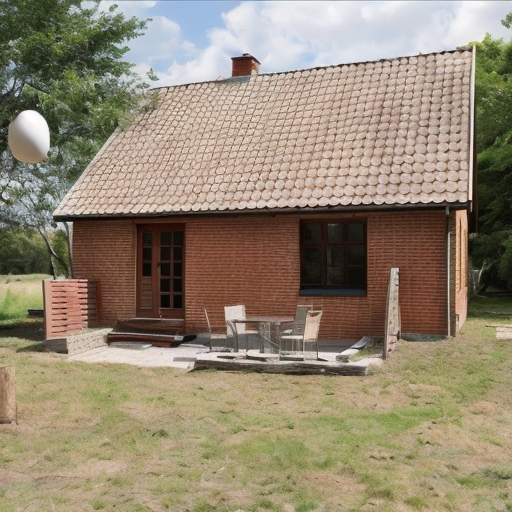

In [123]:
image

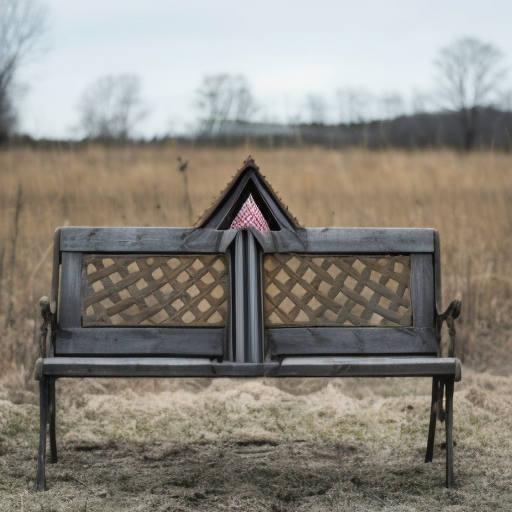

In [106]:
image

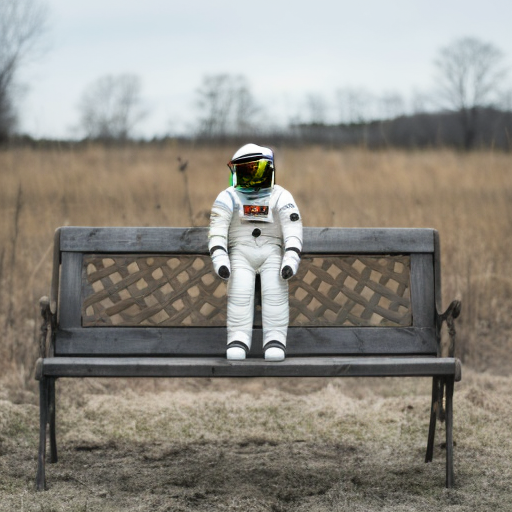

In [26]:
image

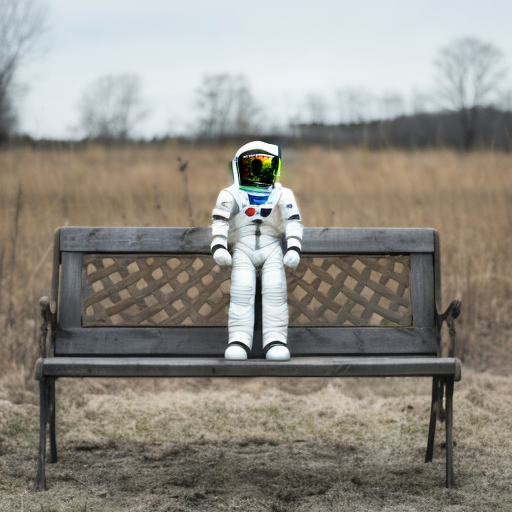

In [11]:
image